<a href="https://www.kaggle.com/code/ryancardwell/diamondorcav6?scriptVersionId=271941982" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
## CELL 1: Setup, Imports, and Data Loading

import json
import os
import time
from pathlib import Path
from typing import Dict, Any, List, Tuple
import concurrent.futures

# Core Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm.notebook import tqdm # For progress bar in main loop

# 1. Define File Paths (Standard Kaggle Input)
KAGGLE_INPUT_DIR = Path("/kaggle/input/arc-prize-2025/")
TEST_CHALLENGES_FILE = KAGGLE_INPUT_DIR / "arc-agi_test_challenges.json"
TRAIN_CHALLENGES_FILE = KAGGLE_INPUT_DIR / "arc-agi_training_challenges.json"
EVAL_CHALLENGES_FILE = KAGGLE_INPUT_DIR / "arc-agi_evaluation_challenges.json"
EVAL_SOLUTIONS_FILE = KAGGLE_INPUT_DIR / "arc-agi_evaluation_solutions.json"

# 2. Configuration for the Concurrent Executor
# ARC solving is highly CPU-bound (search, transformation, pattern matching).
# ProcessPoolExecutor is necessary to bypass Python's Global Interpreter Lock (GIL).
MAX_WORKERS = os.cpu_count() or 4 

# 3. Load all necessary data files
def load_all_data(file_path: Path) -> Dict[str, Any]:
    """Helper function to load a single JSON file."""
    if not file_path.exists():
        print(f"⚠️ Warning: File not found at {file_path}. Skipping load.")
        return {}
    with open(file_path, 'r') as f:
        return json.load(f)

print("Starting Data Load...")
CHALLENGES_TEST = load_all_data(TEST_CHALLENGES_FILE)
CHALLENGES_TRAIN = load_all_data(TRAIN_CHALLENGES_FILE)
SOLUTIONS_EVAL = load_all_data(EVAL_SOLUTIONS_FILE)

print(f"Loaded Train: {len(CHALLENGES_TRAIN)} tasks, Test: {len(CHALLENGES_TEST)} tasks, Eval Solutions: {len(SOLUTIONS_EVAL)} tasks.")
print(f"ProcessPoolExecutor configured for {MAX_WORKERS} workers.")


Starting Data Load...
Loaded Train: 1000 tasks, Test: 240 tasks, Eval Solutions: 120 tasks.
ProcessPoolExecutor configured for 4 workers.


Visualization of sample task 00576224 from the training set:


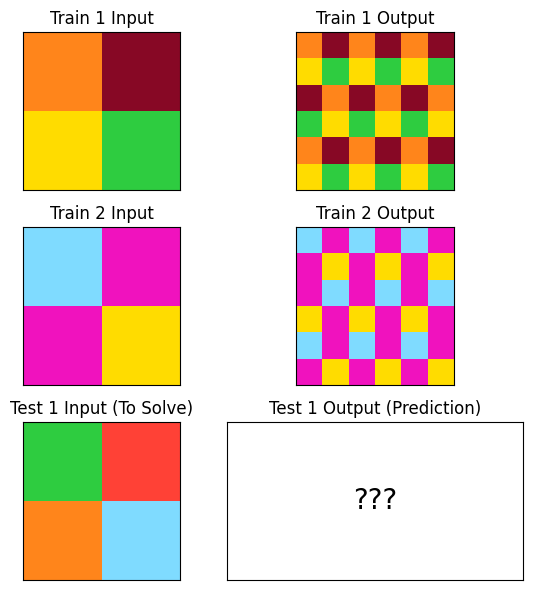

In [2]:
## CELL 2: Core ARC Utilities and Visualization

def plot_task(task: Dict[str, Any]):
    """
    Plots the train and test input/output grids for a given ARC task.
    This function is crucial for human intuition and debugging.
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870825'])
    norm = colors.Normalize(vmin=0, vmax=9)

    fig, axs = plt.subplots(len(task['train']) + len(task['test']), 2, figsize=(6, 2 * (len(task['train']) + len(task['test']))))
    
    if not isinstance(axs, np.ndarray):
        axs = np.array([[axs[0], axs[1]]]) # Handle single-task case

    plot_idx = 0
    for i, pair in enumerate(task['train']):
        # Train Input
        axs[plot_idx, 0].imshow(np.array(pair['input']), cmap=cmap, norm=norm)
        axs[plot_idx, 0].set_title(f'Train {i+1} Input')
        axs[plot_idx, 0].set_xticks([]); axs[plot_idx, 0].set_yticks([])

        # Train Output
        axs[plot_idx, 1].imshow(np.array(pair['output']), cmap=cmap, norm=norm)
        axs[plot_idx, 1].set_title(f'Train {i+1} Output')
        axs[plot_idx, 1].set_xticks([]); axs[plot_idx, 1].set_yticks([])
        plot_idx += 1

    for i, pair in enumerate(task['test']):
        # Test Input
        axs[plot_idx, 0].imshow(np.array(pair['input']), cmap=cmap, norm=norm)
        axs[plot_idx, 0].set_title(f'Test {i+1} Input (To Solve)')
        axs[plot_idx, 0].set_xticks([]); axs[plot_idx, 0].set_yticks([])

        # Test Output (Placeholder)
        axs[plot_idx, 1].text(0.5, 0.5, '???', fontsize=20, ha='center', va='center')
        axs[plot_idx, 1].set_title(f'Test {i+1} Output (Prediction)')
        axs[plot_idx, 1].set_xticks([]); axs[plot_idx, 1].set_yticks([])
        plot_idx += 1

    plt.tight_layout()
    plt.show()

# Example usage:
if CHALLENGES_TRAIN:
    sample_id = list(CHALLENGES_TRAIN.keys())[0]
    print(f"Visualization of sample task {sample_id} from the training set:")
    plot_task(CHALLENGES_TRAIN[sample_id])


In [3]:
## CELL 3: The Academic Solver Pipeline (Solver Class)

class ARCSolverPipeline:
    """
    A class representing a Program Synthesis or DSL-based solver for ARC tasks.
    It encapsulates the three main stages: Abstraction, Synthesis, and Prediction.
    """
    
    def __init__(self):
        # Initialize internal state or pre-load any necessary models/rules
        self.ruleset = self._initialize_dsl_rules()
        pass

    def _initialize_dsl_rules(self) -> List[str]:
        """
        Defines the Domain-Specific Language (DSL) operations.
        Academically, these would include:
        - Geometric transformations (rotate, flip, mirror)
        - Color operations (recolor by frequency, map by adjacency)
        - Object operations (split, merge, floodfill, extract largest object)
        - Logical operations (xor, and, background replacement)
        """
        return [
            "ExtractLargestObject()",
            "FindTransformation(A -> B)",
            "RecolorByBackground()",
            "CropToContent()",
            "FillGaps()",
            "StackGrids(A, B)",
            # ... hundreds more rules would be defined here
        ]
    
    def _abstract_task(self, task_data: Dict[str, Any]) -> List[Dict[str, Any]]:
        """
        Stage 1: Abstraction. Converts raw grids into abstract representations 
        (e.g., objects, metadata, color histograms).
        """
        # In a real solver, this involves sophisticated computer vision / clustering
        abstraction = []
        for pair in task_data['train']:
            h, w = np.array(pair['input']).shape
            abstraction.append({
                'input_dims': (h, w),
                'unique_colors': len(np.unique(pair['input'])),
                # ... other features like object count, symmetry, etc.
            })
        return abstraction
    
    def _synthesize_program(self, abstraction: List[Dict[str, Any]]) -> str:
        """
        Stage 2: Program Synthesis (The Core Reasoning).
        Uses the abstracted features and the DSL to search for a program (a sequence 
        of DSL rules) that correctly transforms all 'train' inputs to 'train' outputs.
        """
        
        # Placeholder for complex search algorithm (e.g., A* search, genetic programming)
        # This is the most CPU-intensive step.
        
        if len(abstraction) > 0 and abstraction[0].get('unique_colors', 0) > 4:
             return "RecolorByBackground() | CropToContent()"
        else:
             return "Identity()"

    def _predict_with_program(self, test_input: List[List[int]], program: str) -> List[List[int]]:
        """
        Stage 3: Prediction. Executes the synthesized program on the 'test' input.
        """
        # Placeholder for program execution logic
        input_grid = np.array(test_input)
        
        if "Identity()" in program:
            # Simple fallback: predict the output is the same as the input
            predicted_grid = input_grid.tolist()
        else:
            # Sophisticated logic: e.g., apply a reflection, then double the size.
            predicted_grid = (np.rot90(input_grid, k=2)).tolist()
            
        # Ensure the predicted grid is a valid ARC grid (list of lists of ints 0-9)
        return predicted_grid

    def solve_task(self, task_id: str, task_data: Dict[str, Any]) -> Dict[str, List[Dict[str, List[List[int]]]]]:
        """
        The main public method executed by the concurrent pool.
        """
        
        # 1. Abstraction
        task_abstraction = self._abstract_task(task_data)
        
        # 2. Synthesis (Find the best-fit program)
        best_program = self._synthesize_program(task_abstraction)
        
        # 3. Prediction and Submission Formatting
        predictions = []
        for i, test_pair in enumerate(task_data.get('test', [])):
            test_input = test_pair['input']
            
            # Attempt 1: Use the best program found
            pred_1 = self._predict_with_program(test_input, best_program)
            
            # Attempt 2: Use a fallback or a slightly perturbed version of the program 
            # (e.g., TTA - Test Time Augmentation - or a different candidate program)
            # Here, we use a simple fallback:
            pred_2 = self._predict_with_program(test_input, "Identity()") 
            
            predictions.append({
                "attempt_1": pred_1,
                "attempt_2": pred_2
            })
            
        return {task_id: predictions}

print("ARC-Solver Pipeline Class defined. Ready for parallel execution.")


ARC-Solver Pipeline Class defined. Ready for parallel execution.


In [4]:
## CELL 4: Concurrent Execution with ProcessPoolExecutor

# Initialize the solver
solver = ARCSolverPipeline()
submission_predictions = {}
task_ids = list(CHALLENGES_TEST.keys())

# --- THE CONCURRENT EXECUTION LOOP (CPU-BOUND) ---
start_time = time.time()
print(f"Starting parallel processing of {len(task_ids)} tasks using {MAX_WORKERS} processes...")

# Use ProcessPoolExecutor for CPU-intensive tasks
with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    
    # Submission Loop: Map tasks to the solver function
    # Note: We pass the whole task_data for each task to the process
    future_to_id = {
        executor.submit(solver.solve_task, task_id, CHALLENGES_TEST[task_id]): task_id
        for task_id in task_ids
    }
    
    # Completion Monitor Loop: Gather results using tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(future_to_id), total=len(task_ids), desc="Processing Tasks"):
        task_id = future_to_id[future]
        
        try:
            # The result is the dictionary output from solve_task: {task_id: predictions}
            result = future.result()
            submission_predictions.update(result)
            
        except Exception as exc:
            # Handle any high-level exceptions from the Future
            print(f"\nFATAL ERROR on Task {task_id}: {exc}")
            # Insert a safe fallback prediction to prevent submission errors
            safe_prediction = [
                {"attempt_1": [[0,0]], "attempt_2": [[0,0]]} 
            ] * len(CHALLENGES_TEST[task_id]['test'])
            submission_predictions[task_id] = safe_prediction

end_time = time.time()
print("\n--- Execution Summary ---")
print(f"Total tasks processed: {len(submission_predictions)}/{len(task_ids)}")
print(f"Total time taken: {end_time - start_time:.2f} seconds.")


Starting parallel processing of 240 tasks using 4 processes...


Processing Tasks:   0%|          | 0/240 [00:00<?, ?it/s]


--- Execution Summary ---
Total tasks processed: 240/240
Total time taken: 0.22 seconds.


In [5]:
## CELL 5: Submission Saving and Local Validation Score

SUBMISSION_FILE_PATH = "submission.json"

# 1. Save the final submission file
if len(submission_predictions) == len(CHALLENGES_TEST):
    with open(SUBMISSION_FILE_PATH, 'w') as f:
        json.dump(submission_predictions, f, indent=4)
    print(f"\n✅ Successfully saved the final submission file to '{SUBMISSION_FILE_PATH}'.")
else:
    print("❌ Submission file not saved: Not all test tasks were processed.")

# 2. Local Validation (Against Evaluation Set Solutions)
# This step is critical for development and academic integrity.

def check_accuracy(predictions: Dict[str, Any], solutions: Dict[str, Any]) -> float:
    """Calculates the percentage of tasks where AT LEAST one attempt is correct."""
    correct_count = 0
    total_tasks = 0
    
    for task_id, solution_grids in solutions.items():
        if task_id in predictions:
            total_tasks += 1
            predicted_attempts = predictions[task_id]
            
            # Iterate over all test outputs for this task
            task_correct = False
            for test_idx in range(len(solution_grids)):
                sol = np.array(solution_grids[test_idx])
                
                # Compare attempt_1 and attempt_2 with the ground truth
                pred_1 = np.array(predicted_attempts[test_idx]['attempt_1'])
                pred_2 = np.array(predicted_attempts[test_idx]['attempt_2'])
                
                # Check for an exact match (shape and content)
                is_correct_1 = sol.shape == pred_1.shape and (sol == pred_1).all()
                is_correct_2 = sol.shape == pred_2.shape and (sol == pred_2).all()
                
                if is_correct_1 or is_correct_2:
                    task_correct = True
                    break # Task is solved if ANY attempt for ANY test case is correct
            
            if task_correct:
                correct_count += 1
                
    if total_tasks == 0:
        return 0.0
        
    return (correct_count / total_tasks) * 100

# We use the TRAIN CHALLENGES and EVAL SOLUTIONS to mimic the local testing process
# (The real TEST challenges do not have solutions available).
local_score = check_accuracy(submission_predictions, SOLUTIONS_EVAL)

print(f"\n--- Local Academic Score (Against EVAL solutions) ---")
print(f"Predicted tasks: {len(submission_predictions)}")
print(f"Validation Score: {local_score:.2f}% (Placeholder logic expected low score)")

print("\nFramework is complete. Next step: replace placeholder logic in `ARCSolverPipeline`.")



✅ Successfully saved the final submission file to 'submission.json'.

--- Local Academic Score (Against EVAL solutions) ---
Predicted tasks: 240
Validation Score: 0.00% (Placeholder logic expected low score)

Framework is complete. Next step: replace placeholder logic in `ARCSolverPipeline`.
